# RANK

In [1]:
import numpy as np
import pandas as pd
import sqlite3

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

### GET COMPANIES AND CLOSE HISTORIES

In [2]:
con = sqlite3.connect('market.db')

companies = pd.read_sql('SELECT * FROM sp5_table' , con)

price_histories = (
    pd.read_sql('SELECT * FROM sp5_close_histories', con, parse_dates=['Date'])
    .pivot(index='Date', columns='Symbol', values='Close'))

# display(companies)
# display(close_histories)

### GET CAGR, QUANTILE, AND RANK HISTORIES

* CAGR - Compunded Annual Growth Rate

In [3]:
def get_cagr_histories(df, days):
    return (((df/df.shift(days))**(252/days) - 1)*100).dropna(axis=0, how='all')


def get_quantile_histories(df, days, q):
    return df.rolling(days).quantile(q).dropna(axis=0, how='all')


def get_tail(df, days):
    return df.tail(days).dropna(axis=1, how='any')


def get_rank_histories(df):
    return df.rank(axis=1, method='first', ascending=False).astype('int64')


cagr_days = 63
q_days = 252
q = 0.25
tail_days = 2*252

cagr_histories = get_cagr_histories(price_histories, cagr_days)
quantile_histories = get_quantile_histories(cagr_histories, q_days, q)
tail_histories = get_tail(quantile_histories, tail_days)
rank_histories = get_rank_histories(tail_histories)

# display(carg_histories)
# display(quantile_histories)
# display(rank_histories)

# PLOT TOP

In [4]:
def get_top_symbols(rank_histories, num_top):
    return rank_histories.iloc[-1].nsmallest(num_top).index.to_list()


def get_companies(companies, symbols):
    return companies.set_index('Symbol').loc[symbols].reset_index()

### TOP SYMBOLS: FIRST QUANTILE

In [5]:
cagr_days = 63
q_days = 252
q = 0.25
tail_days = 2*252

cagr_histories = get_cagr_histories(price_histories, cagr_days)
quantile_histories = get_quantile_histories(cagr_histories, q_days, q)
tail_histories = get_tail(quantile_histories, tail_days)
rank_histories = get_rank_histories(tail_histories)

top_symbols = get_top_symbols(rank_histories, 25)
top_companies = get_companies(companies, top_symbols)

display(top_companies)

,Symbol,Name,Sector,Industry
0,DVN,Devon,Energy,Oil & Gas Exploration & Production
1,MRO,Marathon Oil,Energy,Oil & Gas Exploration & Production
2,CF,CF Industries,Materials,Fertilizers & Agricultural Chemicals
3,COP,ConocoPhillips,Energy,Oil & Gas Exploration & Production
4,EOG,EOG Resources,Energy,Oil & Gas Exploration & Production
5,EXC,Exelon,Utilities,Multi-Utilities
6,APA,APA Corporation,Energy,Oil & Gas Exploration & Production
7,AZO,AutoZone,Consumer Discretionary,Specialty Stores
8,COST,Costco,Consumer Staples,Hypermarkets & Super Centers
9,PLD,Prologis,Real Estate,Industrial REITs


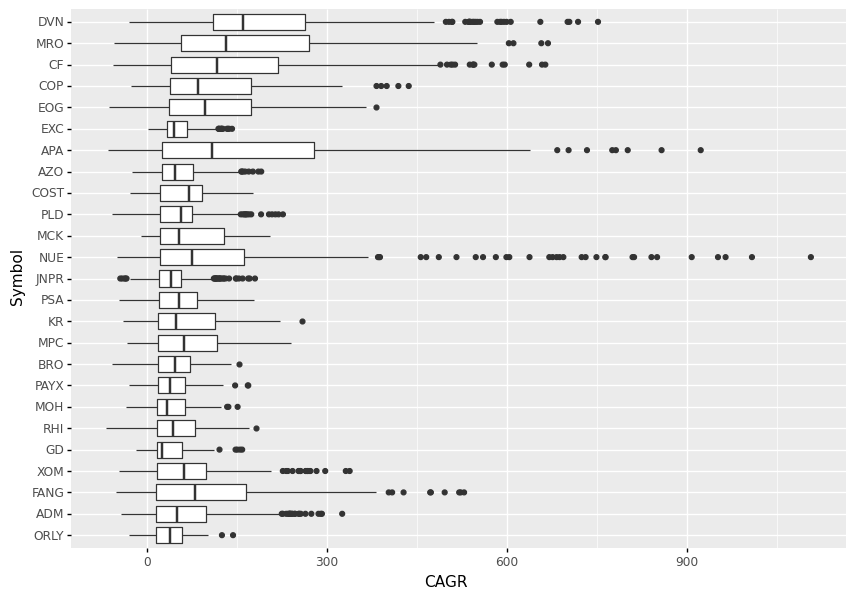

<ggplot: (8780727088291)>

In [6]:
df = (cagr_histories[top_symbols]
    .pipe(get_tail, q_days)
    .reset_index()
    .melt(id_vars='Date', value_name='CAGR'))  
      
p = (p9.ggplot(df)
    + p9.theme(figure_size=(10, 7))
    + p9.geom_boxplot(mapping=p9.aes(x='Symbol', y='CAGR'))
    + p9.coord_flip()
    + p9.scale_x_discrete(limits=top_symbols[::-1]))

display(p)

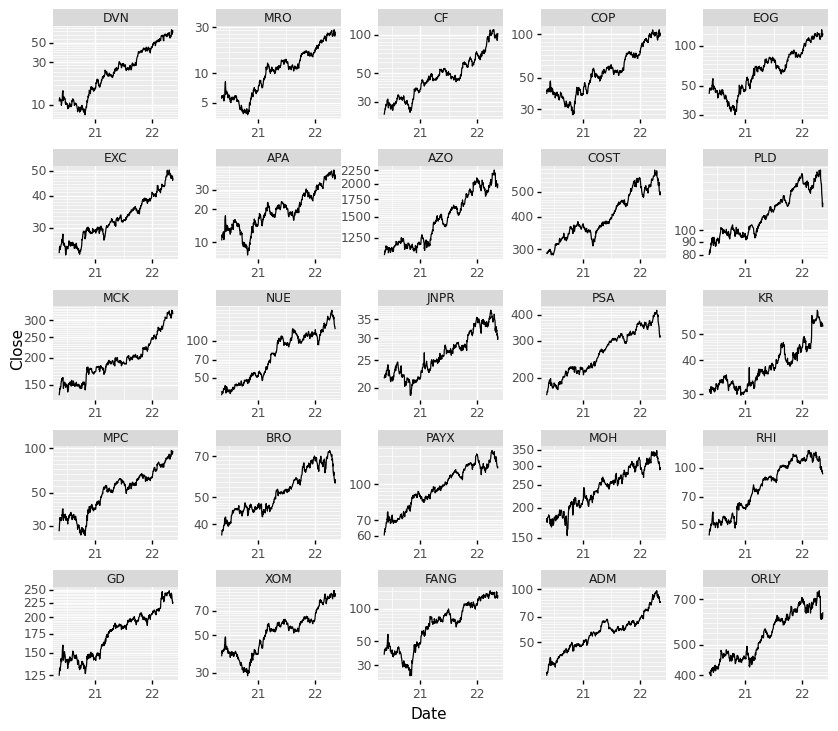

<ggplot: (8780610920692)>

In [7]:
df = (price_histories[top_symbols]
    .pipe(get_tail, tail_days)
    .reset_index()
    .melt(id_vars='Date', value_name='Close'))

df['Symbol'] = (df['Symbol']
    .astype('category')
    .cat.reorder_categories(top_symbols)) 

width = 10
ncol = 5
nrow = np.ceil(len(df['Symbol'].unique())/ncol)

p = (p9.ggplot(df)
    + p9.theme(figure_size=(width, 0.85*width/ncol*nrow))
    + p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y'))
    + p9.geom_line(mapping=p9.aes(x='Date', y='Close'))
    + p9.scale_y_log10()
    + p9.facet_wrap('Symbol', ncol=ncol, scales='free')
    + p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30}))

display(p)

### TOP SYMBOLS: SECOND QUANTILE

In [8]:
carg_days = 63
q_days = 252
q = 0.50
tail_days = 2*252

cagr_histories = get_cagr_histories(price_histories, cagr_days)
quantile_histories = get_quantile_histories(cagr_histories, q_days, q)
tail_histories = get_tail(quantile_histories, tail_days)
rank_histories = get_rank_histories(tail_histories)

top_symbols = get_top_symbols(rank_histories, 25)
top_companies = get_companies(companies, top_symbols)

display(top_companies)

,Symbol,Name,Sector,Industry
0,DVN,Devon,Energy,Oil & Gas Exploration & Production
1,MRO,Marathon Oil,Energy,Oil & Gas Exploration & Production
2,NVDA,Nvidia,Information Technology,Semiconductors
3,CF,CF Industries,Materials,Fertilizers & Agricultural Chemicals
4,APA,APA Corporation,Energy,Oil & Gas Exploration & Production
5,EOG,EOG Resources,Energy,Oil & Gas Exploration & Production
6,COP,ConocoPhillips,Energy,Oil & Gas Exploration & Production
7,FANG,Diamondback,Energy,Oil & Gas Exploration & Production
8,FTNT,Fortinet,Information Technology,Systems Software
9,CVX,Chevron,Energy,Integrated Oil & Gas


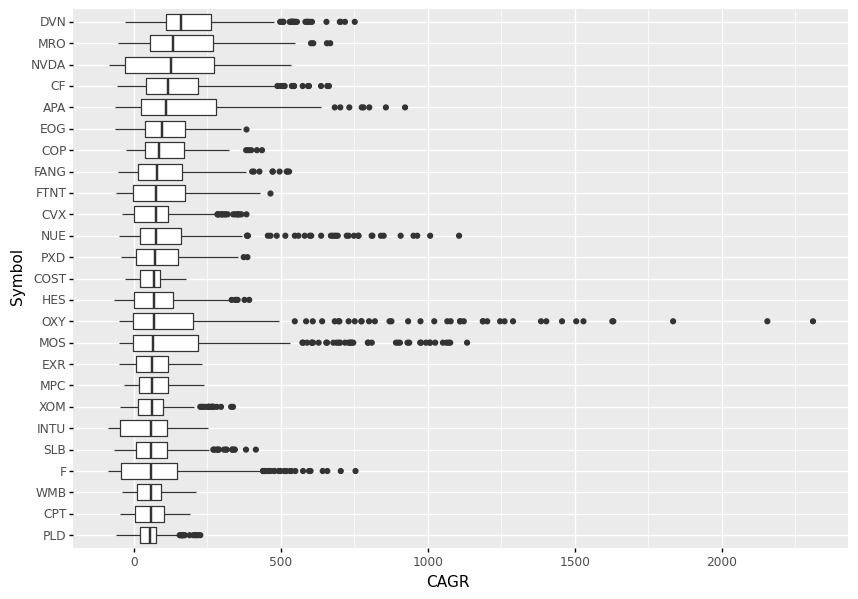

<ggplot: (8780626901131)>

In [9]:
df = (cagr_histories[top_symbols]
    .pipe(get_tail, q_days)
    .reset_index()
    .melt(id_vars='Date', value_name='CAGR'))  
      
p = (p9.ggplot(df)
    + p9.theme(figure_size=(10, 7))
    + p9.geom_boxplot(mapping=p9.aes(x='Symbol', y='CAGR'))
    + p9.coord_flip()
    + p9.scale_x_discrete(limits=top_symbols[::-1]))

display(p)

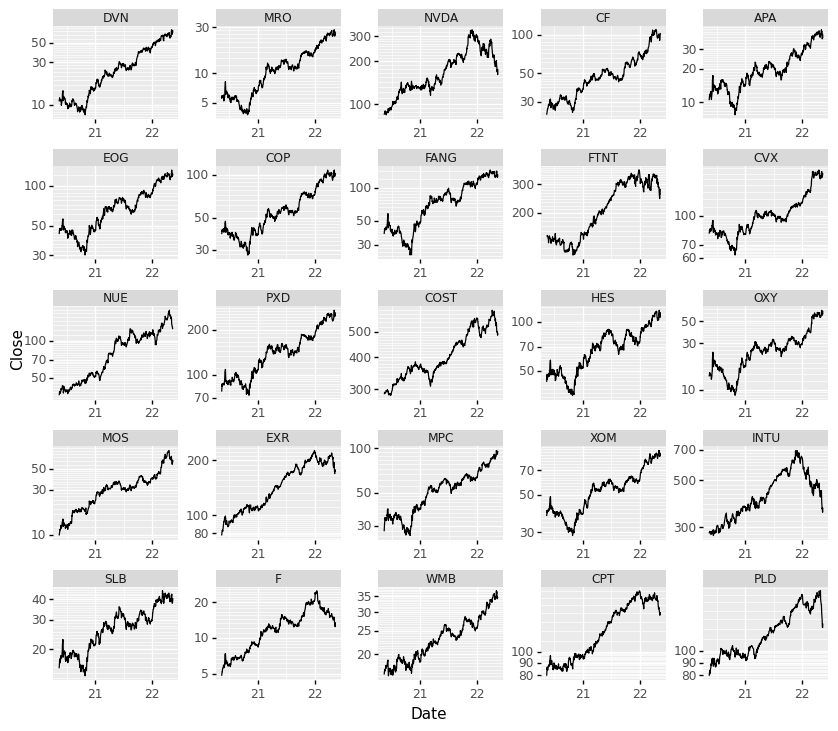

<ggplot: (8780624901943)>

In [10]:
df = (price_histories[top_symbols]
    .pipe(get_tail, tail_days)
    .reset_index()
    .melt(id_vars='Date', value_name='Close'))

df['Symbol'] = (df['Symbol']
    .astype('category')
    .cat.reorder_categories(top_symbols)) 

width = 10
ncol = 5
nrow = np.ceil(len(df['Symbol'].unique())/ncol)

p = (p9.ggplot(df)
    + p9.theme(figure_size=(width, 0.85*width/ncol*nrow))
    + p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y'))
    + p9.geom_line(mapping=p9.aes(x='Date', y='Close'))
    + p9.scale_y_log10()
    + p9.facet_wrap('Symbol', ncol=ncol, scales='free')
    + p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30}))

display(p)

### TOP SYMBOLS: THIRD QUANTILE

In [11]:
carg_days = 63
q_days = 252
q = 0.75
tail_days = 2*252

cagr_histories = get_cagr_histories(price_histories, cagr_days)
quantile_histories = get_quantile_histories(cagr_histories, q_days, q)
tail_histories = get_tail(quantile_histories, tail_days)
rank_histories = get_rank_histories(tail_histories)

top_symbols = get_top_symbols(rank_histories, 25)
top_companies = get_companies(companies, top_symbols)

display(top_companies)

,Symbol,Name,Sector,Industry
0,MRNA,Moderna,Health Care,Biotechnology
1,APA,APA Corporation,Energy,Oil & Gas Exploration & Production
2,NVDA,Nvidia,Information Technology,Semiconductors
3,MRO,Marathon Oil,Energy,Oil & Gas Exploration & Production
4,DVN,Devon,Energy,Oil & Gas Exploration & Production
5,CTRA,Coterra,Energy,Oil & Gas Exploration & Production
6,MOS,Mosaic,Materials,Fertilizers & Agricultural Chemicals
7,CF,CF Industries,Materials,Fertilizers & Agricultural Chemicals
8,AMD,AMD,Information Technology,Semiconductors
9,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production


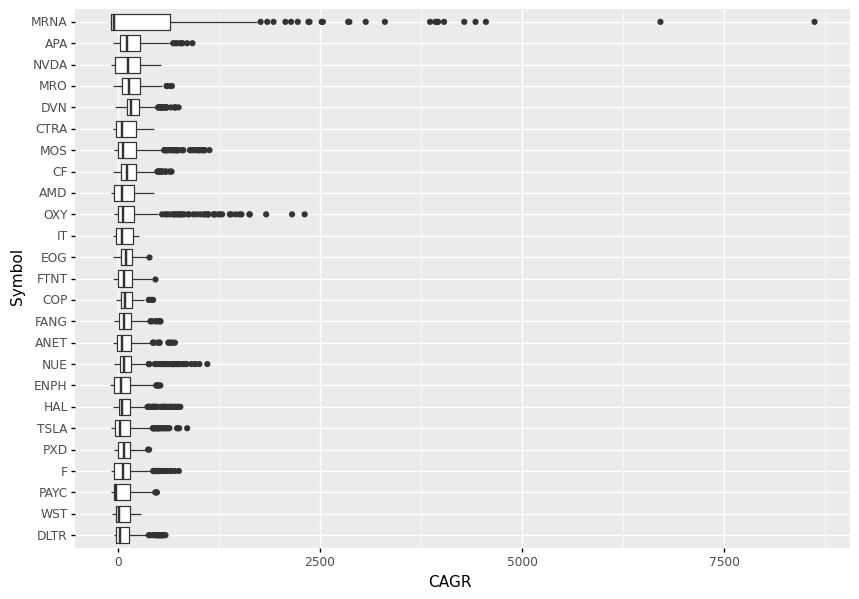

<ggplot: (8780732071111)>

In [12]:
df = (cagr_histories[top_symbols]
    .pipe(get_tail, q_days)
    .reset_index()
    .melt(id_vars='Date', value_name='CAGR'))  
      
p = (p9.ggplot(df)
    + p9.theme(figure_size=(10, 7))
    + p9.geom_boxplot(mapping=p9.aes(x='Symbol', y='CAGR'))
    + p9.coord_flip()
    + p9.scale_x_discrete(limits=top_symbols[::-1]))

display(p)

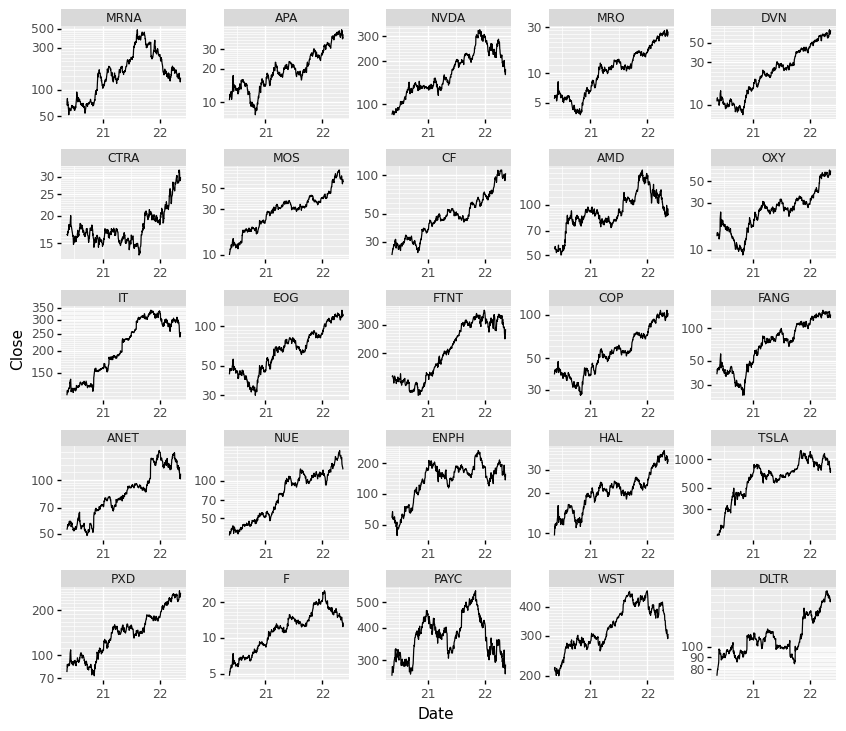

<ggplot: (8780641460514)>

In [13]:
df = (price_histories[top_symbols]
    .pipe(get_tail, tail_days)
    .reset_index()
    .melt(id_vars='Date', value_name='Close'))

df['Symbol'] = (df['Symbol']
    .astype('category')
    .cat.reorder_categories(top_symbols)) 

width = 10
ncol = 5
nrow = np.ceil(len(df['Symbol'].unique())/ncol)

p = (p9.ggplot(df)
    + p9.theme(figure_size=(width, 0.85*width/ncol*nrow))
    + p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y'))
    + p9.geom_line(mapping=p9.aes(x='Date', y='Close'))
    + p9.scale_y_log10()
    + p9.facet_wrap('Symbol', ncol=ncol, scales='free')
    + p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30}))

display(p)